In [1]:
from brian2 import *
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import sys
import os.path
import random
import math

WARNING    /tmp/ipykernel_63334/3730742196.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
 [py.warnings]


In [2]:
# Global Parameters
El = -70 * mV
Vt = -65 * mV
taum = 20 * ms

# STDP params
taupre = 5 * ms
taupost = 25 * ms
wmax = 0.5 * mV
Apre = 0.01*mV
Apost = (-Apre * taupre / taupost * 1.05)

In [3]:
def elapsed(sec):
    '''
    This function returns the elapsed time
    '''

    if sec < 60:
        return str(round(sec)) + ' secs'

    elif sec < 3600:
        return str(round((sec) / 60)) + ' mins'

    else:
        return str(round(sec / 3600)) + ' hrs'


def visualizeConnections(S):
    '''
     This function visualizes the connection
     between neurons
    '''

    src_len = len(S.source)
    tgt_len = len(S.target)

    print(src_len, tgt_len)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.zeros(src_len), np.arange(src_len), 'ok', ms=1)
    plt.plot(np.ones(tgt_len), np.arange(tgt_len), 'ok', ms=1)

    for i, j in zip(S.i, S.j):
            #print(i , j)
        plt.plot([0, 1], [i, j], '-k', ms=1)

    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1, max(src_len, tgt_len))

    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok', ms=1)
    plt.xlim(-1, src_len)
    plt.ylim(-1, tgt_len)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

    plt.show()


[[0 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [0 1 1 1 0]]
Circle Dim: (5, 5)
Cross Dim: (5, 5)


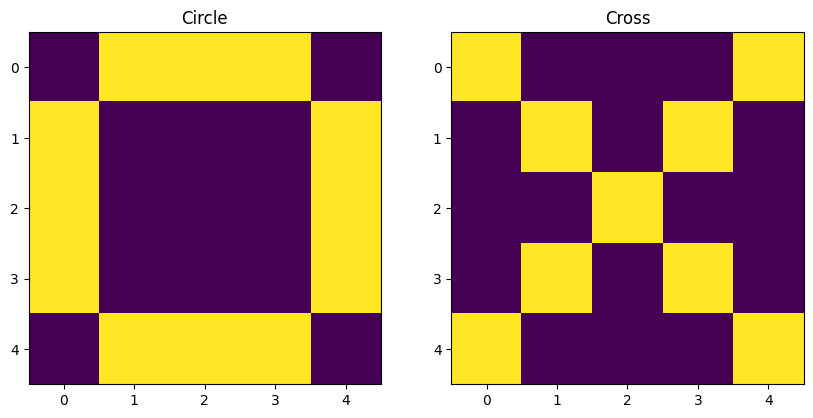

In [4]:
start_time = time.time()

circle_img = np.array([[0, 1, 1, 1, 0],
                        [1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1],
                        [0, 1, 1, 1, 0]])


# cross_img = np.array(cross_small)
cross_img = np.array([[1, 0, 0, 0, 1],
                    [0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 0],
                    [0, 1, 0, 1, 0],
                    [1, 0, 0, 0, 1]])

print(circle_img)

print('Circle Dim: {}'.format(circle_img.shape))
print('Cross Dim: {}'.format(cross_img.shape))

# Plot the images
fig1 = plt.figure(figsize=(10, 5))

ax = fig1.add_subplot(121)
plt.imshow(circle_img)
plt.title("Circle")

ax = fig1.add_subplot(122)
plt.imshow(cross_img)
plt.title("Cross")

plt.show()

In [5]:
circle_img = circle_img.flatten()
cross_img = cross_img.flatten()
print(cross_img)
# LIF EQUATION

lif_eqs = '''
dv/dt = (El-v)/taum : volt

'''
data = [circle_img, cross_img]
input_rate_circle = TimedArray(data[0] *255*Hz, dt=1*ms)
input_rate_cross = TimedArray(data[1] *255*Hz, dt=1*ms)
circle_scale = data[0]*255*Hz
cross_scale = data[1]*255*Hz
##### GENERATE POISSON INPUT #####

poisson_circle = PoissonGroup(25, rates = circle_scale, name = 'PoissongroupCircle')
poisson_cross = PoissonGroup(25, rates = cross_scale, name = 'PoissongroupCross')


[1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1]


In [6]:
#Create a single neuron group and partition

neurons = NeuronGroup(50, lif_eqs, threshold= 'v>Vt', reset = 'v= El', refractory=5*ms, method = 'euler',name= 'neurons')
#Population that like circle
circ_neu = neurons[0:25]
circ_neu.v = 'El + rand()*Vt'

#Population that like cross 
cross_neu = neurons[25:]
cross_neu.v = 'El + rand()*Vt'

#Synapses
syn_inp_circ = Synapses(poisson_circle, neurons, 'w : volt', on_pre = 'v+=w')
syn_inp_cross = Synapses(poisson_cross, neurons, model = 'w : volt', on_pre = 'v-=w')
#connections
syn_inp_circ.connect()
syn_inp_cross.connect()

#weights
syn_inp_cross.w = 'rand()*wmax'
syn_inp_circ.w = 'rand()*wmax'
#monitors
spike_mon_circ = SpikeMonitor(circ_neu)
spike_mon_cross = SpikeMonitor(cross_neu)
spike_mon_circ_poi = SpikeMonitor(poisson_circle)
spike_mon_cross_poi = SpikeMonitor(poisson_cross)

state_mon_circ = StateMonitor(syn_inp_circ, ['w'], record=0)
state_mon_cross = StateMonitor(syn_inp_cross, ['w'],record=0)
#Stablish network
net = Network([spike_mon_circ_poi,spike_mon_cross_poi,syn_inp_circ,syn_inp_cross,poisson_circle,poisson_cross,neurons,circ_neu,cross_neu,spike_mon_circ,spike_mon_cross,state_mon_circ,state_mon_cross])
net.store()
time = 3000*ms
net.run(time, report = 'text')


Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 3s


Poisson Circle Spikes: 9193
Poisson Cross Spikes: 6830
Neuron Circle Spikes: 1864
Neuron Cross Spikes: 1631


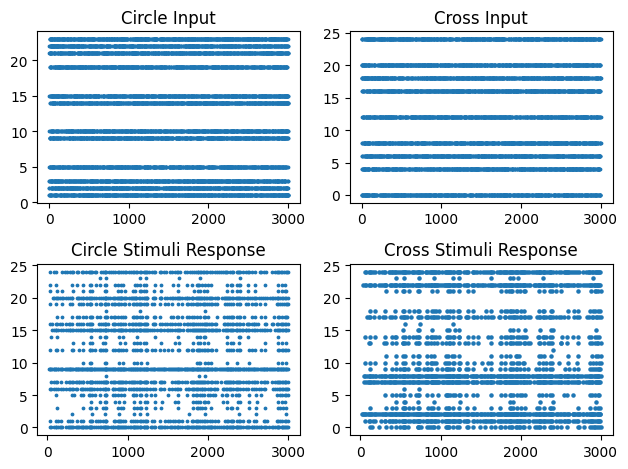

In [11]:
print('Poisson Circle Spikes: {}'.format(spike_mon_circ_poi.num_spikes))
print('Poisson Cross Spikes: {}'.format(spike_mon_cross_poi.num_spikes))

print('Neuron Circle Spikes: {}'.format(spike_mon_circ.num_spikes))
print('Neuron Cross Spikes: {}'.format(spike_mon_cross.num_spikes))

fig, axs = plt.subplots(2,2)
axs[1,0].scatter(spike_mon_circ.t/ms,spike_mon_circ.i, s= 3)
axs[1,0].set_title('Circle Stimuli Response')
axs[1,1].scatter(spike_mon_cross.t/ms,spike_mon_cross.i, s= 5)
axs[1,1].set_title('Cross Stimuli Response')
axs[0,0].scatter(spike_mon_circ_poi.t/ms,spike_mon_circ_poi.i,s=3)
axs[0,0].set_title('Circle Input')
axs[0,1].scatter(spike_mon_cross_poi.t/ms,spike_mon_cross_poi.i,s=3)
axs[0,1].set_title('Cross Input')
fig.tight_layout()
plt.show()

Correlation between input exposure and Neuron grouos activity is not clear, further exploring is required.